In [1]:
import json
import os
import numpy as np

In [2]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [3]:
DATA_PATH = 'data.json'

## Data split

In [4]:
with open(DATA_PATH) as f:
    data = json.load(f)

In [5]:
X = np.array(data['MFCCs'])
y = np.array(data['labels'])

In [6]:
from sklearn.model_selection import train_test_split

test_size = 0.1
val_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)

In [7]:
# convert from 2D to 3D
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Build model

In [8]:
import tensorflow.keras as keras

input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]) # segments, coefficients(13), 1

In [9]:
l2_reg = 0.001
n_classes = len(np.unique(y_train))

model = keras.Sequential()

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

2022-05-31 20:29:46.781886: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-31 20:29:46.815543: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2295700000 Hz
2022-05-31 20:29:46.815989: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558171cb2c50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-31 20:29:46.816024: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-31 20:29:46.817626: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.

In [10]:
lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 6, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 6, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 3, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 1, 32)          9

In [12]:
batch_size = 64
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
         validation_data=(X_val, y_val))

2022-05-31 20:29:47.152655: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
738/738 [==============================] - 41s 54ms/step - loss: 3.6230 - accuracy: 0.0647 - val_loss: 2.8156 - val_accuracy: 0.2659
Epoch 2/50
738/738 [==============================] - 47s 64ms/step - loss: 2.7404 - accuracy: 0.2501 - val_loss: 2.1537 - val_accuracy: 0.4587
Epoch 3/50
738/738 [==============================] - 50s 68ms/step - loss: 2.1631 - accuracy: 0.3990 - val_loss: 1.6397 - val_accuracy: 0.5855
Epoch 4/50
738/738 [==============================] - 49s 67ms/step - loss: 1.7536 - accuracy: 0.5117 - val_loss: 1.3130 - val_accuracy: 0.6742
Epoch 5/50
738/738 [==============================] - 53s 72ms/step - loss: 1.4660 - accuracy: 0.5909 - val_loss: 1.1202 - val_accuracy: 0.7118
Epoch 6/50
738/738 [==============================] - 48s 65ms/step - loss: 1.2430 - accuracy: 0.6581 - val_loss: 0.9969 - val_accuracy: 0.7513
Epoch 7/50
738/738 [==============================] - 45s 61ms/step - loss: 1.1016 - accuracy: 0.6966 - val_loss: 0.8788 - val_accuracy:

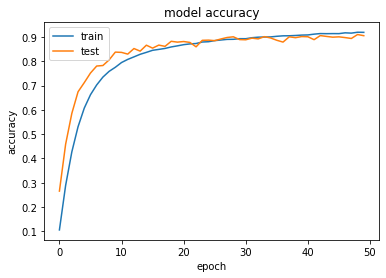

In [13]:
import matplotlib.pyplot as plt
# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

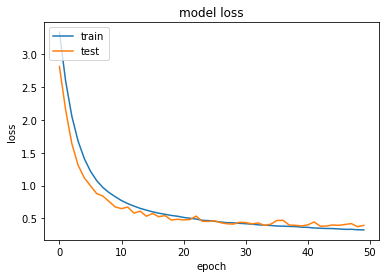

In [14]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate

In [15]:
test_error, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test error: {test_error}, Test accuracy: {test_accuracy}")

183/183 [==============================] - 2s 10ms/step - loss: 0.3651 - accuracy: 0.9092
Test error: 0.3651139438152313, Test accuracy: 0.909200131893158


## Save model

In [16]:
model_path = 'model.h5'
model.save(model_path)

In [17]:
! conda install -c anaconda flask  -y

Solving environment: done

## Package Plan ##

  environment location: /home/karol/anaconda3/envs/aws

  added / updated specs:
    - flask


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    flask-2.0.3                |     pyhd3eb1b0_0          70 KB  anaconda
    itsdangerous-2.0.1         |     pyhd3eb1b0_0          18 KB  anaconda
    ------------------------------------------------------------
                                           Total:          88 KB

The following NEW packages will be INSTALLED:

  flask              anaconda/noarch::flask-2.0.3-pyhd3eb1b0_0
  itsdangerous       anaconda/noarch::itsdangerous-2.0.1-pyhd3eb1b0_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2022.5.1~ --> anaconda::ca-certificates-2022.4.26-h06a4308_0
  certifi            conda-forge::certifi-2022.5.18.1-py39~ --> anac

In [1]:
! conda install -c conda-forge uwsgi -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - ^C
failed

CondaError: KeyboardInterrupt

